In [1]:
# Importing libraries
import glob
import h5py
import mne
import numpy as np
import os
import scipy.io as sio
from matplotlib  import pyplot as plt
import pyntbci
from pyntbci.transformers import CCA

In [2]:
# root directory for extracted data
root_data = r"C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\SN_pilot_data\derivatives"

subjects_covert = ["pilot3_cvep_covert_mgold_61_6521_mod.npz","pilot4_cvep_covert_mgold_61_6521_mod.npz", "pilot5_cvep_covert_mgold_61_6521_mod.npz"]
subjects_overt  = ["pilot3_cvep_overt_mgold_61_6521_mod.npz","pilot4_cvep_overt_mgold_61_6521_mod.npz"]

#loading: COVERT data
X = []
y = []

for subject in subjects_covert:
    
    subject_num = subject.split("_")[0]
    fn = os.path.join(root_data, subject_num, subject).replace('\\','/')
    tmp_covert = np.load(fn)
    X_tmp = tmp_covert["X"]
    y_tmp = tmp_covert["y"]
    V = tmp_covert["V"].T
    fs = tmp_covert["fs"]
    
    X.append(X_tmp)
    y.append(y_tmp)

X = np.squeeze(np.concatenate(X, axis=0)).astype("float32")  # trials channels samples
y = np.concatenate(y, axis=0).astype("uint8")
fr = 120
    

print("X", X.shape, "(trials x channels x samples)")  # EEG
print("y", y.shape, "(trials)")  # labels
print("V", V.shape, "(classes, samples)")  # codes
print("fs", fs, "Hz")  # sampling frequency
print("fr", fr, "Hz")  # presentation rate
print("trial duration was", X.shape[2]/fs,"s")

# # Extract data dimensions
n_trials, n_channels, n_samples = X.shape
n_classes = V.shape[0]

# # Read cap file
path = r"C:\Users\s1081686\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyntbci\capfiles" 
capfile = os.path.join(path, "biosemi64.loc")
with open(capfile, "r") as fid:
    channels = []
    for line in fid.readlines():
        channels.append(line.split("\t")[-1].strip())
print("Channels:", ", ".join(channels))

X (240, 64, 2400) (trials x channels x samples)
y (240,) (trials)
V (2, 252) (classes, samples)
fs 120 Hz
fr 120 Hz
trial duration was 20.0 s
Channels: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, T7, TP7, CP5, CP3, CP1, P1, P3, P5, P7, P9, PO7, PO3, O1, Iz, Oz, POz, Pz, CPz, Fpz, Fp2, AF8, AF4, AFz, Fz, F2, F4, F6, F8, FT8, FC6, FC4, FC2, FCz, Cz, C2, C4, C6, T8, TP8, CP6, CP4, CP2, P2, P4, P6, P8, P10, PO8, PO4, O2


In [3]:
# Create event matrix
E, events = pyntbci.utilities.event_matrix(V, event="duration", onset_event=True)
print("E:", E.shape, "(classes x events x samples)")
print("Events:", ", ".join([str(event) for event in events]))

E: (2, 3, 252) (classes x events x samples)
Events: 2, 4, onset


M: shape: (2, 180, 252) (classes x transient_size*events x samples)


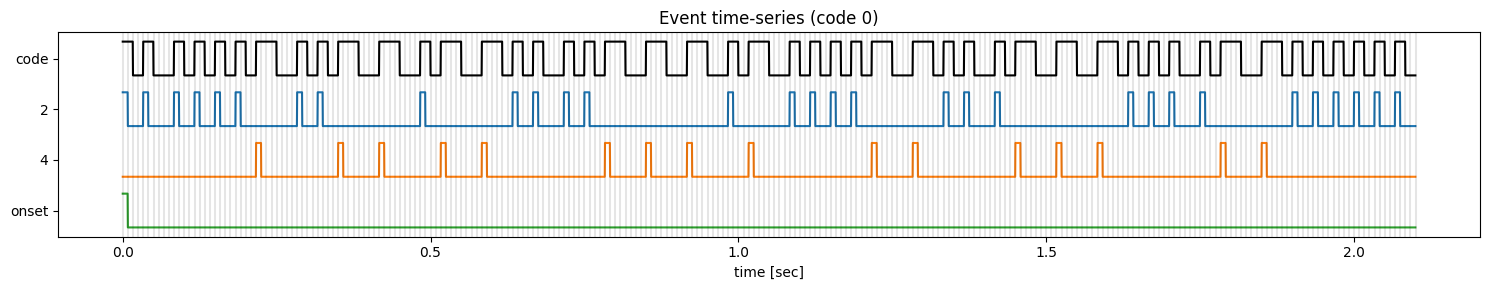

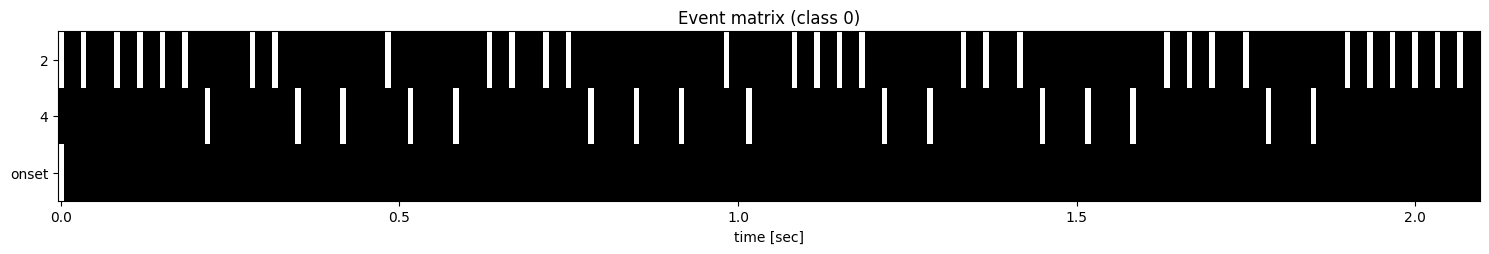

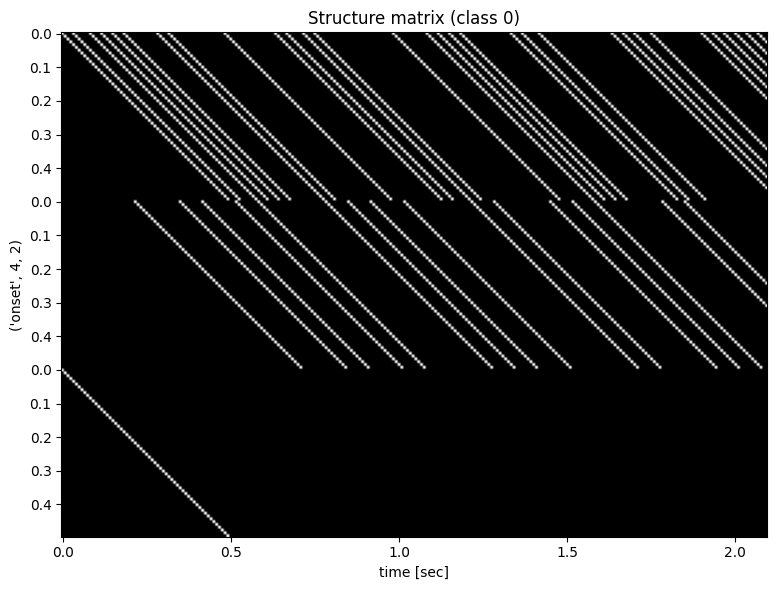

In [4]:
# Visualize event time-series
i_class = 0  # the class to visualize
Vu = V.repeat(20, axis=1)  # upsample to better visualize the sharp edges
Eu = E.repeat(20, axis=2)  # upsample to better visualize the sharp edges
plt.figure(figsize=(15, 3))
plt.plot(np.arange(0, Vu.shape[1]) / (20*fs), Vu[i_class, :], "k")
for i_event in range(E.shape[1]):
    plt.plot(np.arange(0, Eu.shape[2]) / (20*fs), -1.5 * (1 + i_event) + Eu[i_class, i_event, :])
for i in range(1 + int(V.shape[1] / (fs / fr))):
    plt.axvline(i / fr, c="k", alpha=0.1)
plt.yticks(-1.5 * np.arange(0, 1 + E.shape[1]) + 0.5, ("code",) + events)
plt.xlabel("time [sec]")
plt.ylabel("")
plt.title(f"Event time-series (code {i_class})")
plt.tight_layout()

# Visualize event matrix
i_class = 0
plt.figure(figsize=(15, 3))
plt.imshow(E[i_class, :, :], cmap="gray")
plt.gca().set_aspect(10)
plt.xticks(np.arange(0, E.shape[2], 60), np.arange(0, E.shape[2], 60) / fs)
plt.yticks(np.arange(E.shape[1]), events)
plt.xlabel("time [sec]")
plt.title(f"Event matrix (class {i_class})")
plt.tight_layout()

# Create structure matrix
transient_size = int(0.5 * fs)  # 300 ms responses
M = pyntbci.utilities.structure_matrix(E, transient_size)
print("M: shape:", M.shape, "(classes x transient_size*events x samples)")

# Plot structure matrix
i_class = 0  # the class to visualize
plt.figure(figsize=(15, 6))
plt.imshow(M[i_class, :, :], cmap="gray")
plt.xticks(np.arange(0, M.shape[2], 60), np.arange(0, M.shape[2], 60) / fs)
plt.yticks(np.arange(0, E.shape[1] * transient_size, 12), np.tile(np.arange(0, transient_size, 12) / fs, E.shape[1]))
plt.xlabel("time [sec]")
plt.ylabel(events[::-1])
plt.title(f"Structure matrix (class {i_class})")
plt.tight_layout()


w:  (64, 1) (channels)
r:  (144, 1) (transient_size*events)


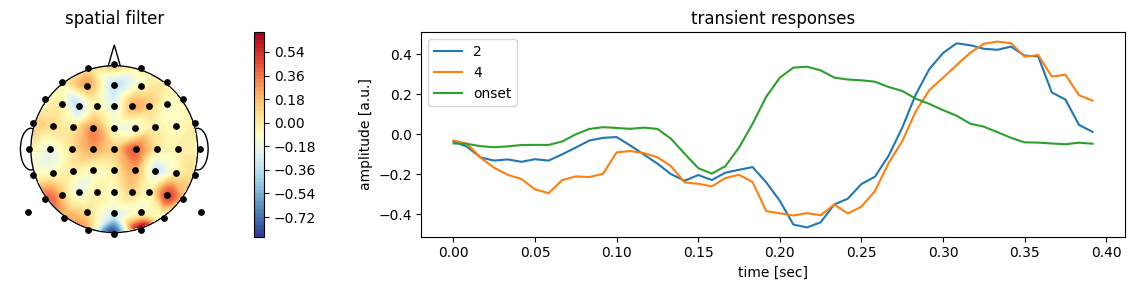

In [5]:
# # Perform CCA decomposition with duration event

# transient_size_vec = np.arange(0.2,0.8,0.1)


# for ts in transient_size_vec:
    
transient_size = 0.4    

'CCA decomposition' 
rcca = pyntbci.classifiers.rCCA(codes=V, fs=fs, event="duration", transient_size=transient_size, onset_event=True)
rcca.fit(X, y)
print("w: ", rcca.w_.shape, "(channels)")
print("r: ", rcca.r_.shape, "(transient_size*events)")

# Plot CCA filters
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
pyntbci.plotting.topoplot(rcca.w_, capfile, ax=ax[0],cbar = True)

ax[0].set_title("spatial filter")
tmp = np.reshape(rcca.r_, (len(rcca.events_), -1))
for i in range(len(rcca.events_)):
    ax[1].plot(np.arange(int(transient_size * fs)) / fs, tmp[i, :])
ax[1].legend(rcca.events_)
ax[1].set_xlabel("time [sec]")
ax[1].set_ylabel("amplitude [a.u.]")
ax[1].set_title("transient responses")
fig.tight_layout()


    

In [6]:
'Cross Validation'
mean_acc = []
ITR = []
transient_size_vec = np.arange(0.2,0.8,0.1)

for ts in transient_size_vec:
    transient_size = ts
    # Cross-validation
    trialtime = 20 # limit trials to a certain duration in seconds
    intertrialtime = 1  # ITI in seconds for computing ITR
    n_samples = int(trialtime * fs)
    n_folds = 4


    # Chronological cross-validation
    folds = np.repeat(np.arange(n_folds), int(n_trials / n_folds))
    print(folds.shape)

    # Loop folds
    accuracy = np.zeros(n_folds)
    for i_fold in range(n_folds):

        # Split data to train and test set
        X_trn, y_trn = X[folds != i_fold, :, :n_samples], y[folds != i_fold]
        X_tst, y_tst = X[folds == i_fold, :, :n_samples], y[folds == i_fold]

        # Train template-matching classifier
        rcca = pyntbci.classifiers.rCCA(codes=V, fs=fs, event="duration", transient_size= transient_size, onset_event=True)
        rcca.fit(X_trn, y_trn)

        # Apply template-matching classifier
        yh_tst = rcca.predict(X_tst)

        # Compute accuracy
        accuracy[i_fold] = np.mean(yh_tst == y_tst)

    # Compute ITR
    itr = pyntbci.utilities.itr(V.shape[1], accuracy, trialtime + intertrialtime)
    mean_acc.append(accuracy.mean())
    ITR.append(itr)
    
    

    # # Plot accuracy (over folds) -- optional
    # plt.figure(figsize=(15, 3))
    # plt.bar(np.arange(n_folds), accuracy)
    # plt.axhline(accuracy.mean(), linestyle='--', alpha=0.5, label="average")
    # plt.axhline(1 / n_classes, color="k", linestyle="--", alpha=0.5, label="chance")
    # plt.xlabel("(test) fold")
    # plt.ylabel("accuracy")
    # plt.legend()
    # plt.title("Chronological cross-validation")
    # plt.tight_layout()

    # Print accuracy (average and standard deviation over folds)
    # print(f"Accuracy: avg={accuracy.mean():.2f} with std={accuracy.std():.2f}")
    # print(f"ITR: avg={itr.mean():.1f} with std={itr.std():.2f}")



(240,)
(240,)
(240,)
(240,)
(240,)
(240,)
(240,)


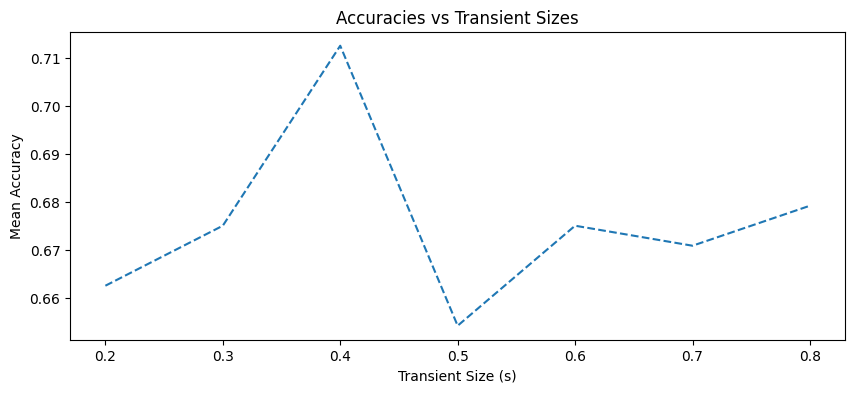

0.7125000000000001


''

In [7]:
     
plt.figure(figsize = (10,4))
plt.plot(transient_size_vec, mean_acc ,linestyle = '--')
plt.xlabel('Transient Size (s)')
plt.ylabel('Mean Accuracy')
plt.title('Accuracies vs Transient Sizes')
plt.show()
print(max(mean_acc))

'different transient sizes for different participants? -- average at those transient sizes?'
''

In [8]:
# # Learning curve
# # Chronological cross-validation
# n_folds = 4 # This will change depending on the size of the data set
# folds = np.repeat(np.arange(n_folds), int(n_trials / n_folds))

# print(int(n_trials / n_folds))
# transient_size = 0.4
# # Set learning curve axis
# train_trials = np.arange(1, 1 + np.sum(folds != 0))
# n_train_trials = train_trials.size

# # Loop folds
# accuracy = np.zeros((n_folds, n_train_trials))
# for i_fold in range(n_folds):

#     # Split data to train and test set
#     X_trn, y_trn = X[folds != i_fold, :, :n_samples], y[folds != i_fold]
#     X_tst, y_tst = X[folds == i_fold, :, :n_samples], y[folds == i_fold]

#     # Loop train trials
#     for i_trial in range(n_train_trials):

#         # Train classifier
#         rcca = pyntbci.classifiers.rCCA(codes=V, fs=fs, event="duration", transient_size=transient_size, onset_event=True)
#         rcca.fit(X_trn[:train_trials[i_trial], :, :], y_trn[:train_trials[i_trial]])

#         # Apply classifier
#         yh_tst = rcca.predict(X_tst)

#         # Compute accuracy
#         accuracy[i_fold, i_trial] = np.mean(yh_tst == y_tst)

# # Plot results
# plt.figure(figsize=(15, 3))
# avg = accuracy.mean(axis=0)
# std = accuracy.std(axis=0)
# plt.plot(train_trials * trialtime, avg, linestyle='-', marker='o', label="rCCA")
# plt.fill_between(train_trials * trialtime, avg + std, avg - std, alpha=0.2, label="_rCCA")
# plt.axhline(1 / n_classes, color="k", linestyle="--", alpha=0.5, label="chance")
# plt.xlabel("learning time [sec]")
# plt.ylabel("accuracy")
# plt.legend()
# plt.title("Learning curve")
# plt.tight_layout()

In [9]:
# ## Decoding Curve

# # Chronological cross-validation
# folds = np.repeat(np.arange(n_folds), int(n_trials / n_folds))

# # Set decoding curve axis
# segmenttime = 0.1  # step size of the decoding curve in seconds
# segments = np.arange(segmenttime, trialtime, segmenttime)
# n_segments = segments.size

# # Loop folds
# accuracy = np.zeros((n_folds, n_segments))
# for i_fold in range(n_folds):

#     # Split data to train and test set
#     X_trn, y_trn = X[folds != i_fold, :, :n_samples], y[folds != i_fold]
#     X_tst, y_tst = X[folds == i_fold, :, :n_samples], y[folds == i_fold]

#     # Setup classifier
#     rcca = pyntbci.classifiers.rCCA(codes=V, fs=fs, event="duration", transient_size=transient_size, onset_event=True)

#     # Train classifier
#     rcca.fit(X_trn, y_trn)

#     # Loop segments
#     for i_segment in range(n_segments):

#         # Apply classifier
#         yh_tst = rcca.predict(X_tst[:, :, :int(fs * segments[i_segment])])

#         # Compute accuracy
#         accuracy[i_fold, i_segment] = np.mean(yh_tst == y_tst)

# # Compute ITR
# time = np.tile(segments[np.newaxis, :], (n_folds, 1))
# itr = pyntbci.utilities.itr(n_classes, accuracy, time + intertrialtime)

# # Plot results
# fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True)
# avg = accuracy.mean(axis=0)
# std = accuracy.std(axis=0)
# ax[0].plot(segments, avg, linestyle='-', marker='o', label="rCCA")
# ax[0].fill_between(segments, avg + std, avg - std, alpha=0.2, label="_rCCA")
# ax[0].axhline(1 / n_classes, color="k", linestyle="--", alpha=0.5, label="chance")
# avg = itr.mean(axis=0)
# std = itr.std(axis=0)
# ax[1].plot(segments, avg, linestyle='-', marker='o', label="rCCA")
# ax[1].fill_between(segments, avg + std, avg - std, alpha=0.2, label="_rCCA")
# ax[1].set_xlabel("decoding time [sec]")
# ax[0].set_ylabel("accuracy")
# ax[1].set_ylabel("ITR [bits/min]")
# ax[0].legend()
# ax[0].set_title("Decoding curve")
# fig.tight_layout()
